In [1]:
import household_contact_tracing.branching_process_models as bpm
from household_contact_tracing.branching_process_controller import BranchingProcessController
from household_contact_tracing.calibration import StandardCalibrationHouseholdLevelTracing
import seaborn as sns
import matplotlib.pyplot as plt

# Calibration tutorial

This is a quick tutorial on how to calibrate the epidemic models. Household structured branching processes are the underlying mathematical framework, and these have several key metrics that are commonly calibrated:
* The household secondary attack rate (probability that a non-index case in a household gets infected)
* The growth rate of the epidemic

The household secondary attack rate typically only depends upon the parameter 'household_pairwise_survival_prob', however this could always be varied. The growth rate of the epidemic is more complicated, and this could depends on every parameter in the model. Typically, we calibrate the epidemic model to a growth rate when there is no contact tracing - an unconstrained epidemic model. Without contact tracing, the epidemic growth rate will depend only upon the household secondary attack rate, the outside household infectivity scaling, and the probability that a case reports their infection and isolates (which depends on the symptomatic proportion of cases).

## Evaluating metrics

By default, models will be initialised with a statistics view, which is able to estimate several metrics in a model, inclduing the growth rate and the household secondary attack rate.

We configure some model parameters, set up a model, run the simulation for 25 days, and then use the statistics view to print some summaries of the simulated epidemic.

In [2]:
params = {'outside_household_infectivity_scaling': 0.1,
            'contact_tracing_success_prob': 0.0, # doesn't matter, no tracing
            'overdispersion': 0.32,
            'asymptomatic_prob': 0.2,
            'asymptomatic_relative_infectivity': 0.35,
            'infection_reporting_prob': 0,
            'contact_trace': False,
            'test_delay': 2,
            'contact_trace_delay': 1,
            'incubation_period_delay': 5,
            'symptom_reporting_delay': 1,
            'household_pairwise_survival_prob': 0.2,
            'do_2_step': False,                      # doesn't matter, no tracing
            'reduce_contacts_by': 0.3,
            'prob_has_trace_app': 0,                 # doesn't matter, no tracing
            'hh_propensity_to_use_trace_app': 1,     # doesn't matter, no tracing
            'test_before_propagate_tracing': True,   # doesn't matter, no tracing
            'starting_infections': 100, 
            'node_will_uptake_isolation_prob': 1,    # doesn't matter, no tracing
            'self_isolation_duration': 0,            # doesn't matter, no tracing
            'quarantine_duration': 0,                # doesn't matter, no tracing
            'transmission_probability_multiplier': 1,
            'propensity_imperfect_quarantine': 0,    # doesn't matter no tracing
            'global_contact_reduction_imperfect_quarantine': 0, # doesn't matter, no tracing

         }

In [3]:
controller = BranchingProcessController(bpm.HouseholdLevelTracing(params))
controller.graph_view.set_display(False) # don't draw the network
controller.csv_view.set_display(False) # don't save csv info
controller.run_simulation({"max_time": 25, "infection_threshold": 1e4})

When estimating the growth rate, it is good practice to discard the first 10 or so days. It can take some time for the distribution of infectious ages to mix properly, and for contact tracing to be initialised.

In [4]:
controller.statistics_view.growth_rate_summary(discard_first_n_days=10)

15 time periods were used to estimate the growth rate.
The estimated growth rate was 8.17% (95.0% CI: 7.09-9.25%) per day.
The estimated doubling time is 8.83 (95.0% CI: 7.84-10.12) days.


In [5]:
controller.statistics_view.household_secondary_attack_rate_summary(use_first_generation_only=False)

Household secondary attack rate summary:
161 local household epidemics were eligible to be included.
All households with completed local epidemics were included. This may lead to a biased sample, as it is possible that local epidemics with a long duration were not included.
There were 280 non-index susceptible individuals exposed, of which 188 were infected.
This yields a household secondary attack rate of 67% (95% CI: 61-72%).


## Household secondary attack rate simulations

Only households with completed local epidemics are included when estimating the household secondary attack rate. This however can lead to biased samples as households with long lasting epidemics might be excluded, and these may be likely to have larger final sizes.

To get around this a second simulation has been implemented that simulates only the local epidemics, and does not simulate outside household transmission. The simulation is run until all the starting households have completed their local epidemics. This will yield a sample that can be used to obtain an unbiased estiamted of the household secondary attack rate. It is necessary to use a larger number of starting infections to obtain the household secondary attack rate.

In [6]:
params['starting_infections'] = 500 # increasing the number of starting infections will increase the sample size
controller = BranchingProcessController(bpm.HouseholdLevelTracing(params))
controller.graph_view.set_display(False) # don't draw the network
controller.csv_view.set_display(False) # don't save csv info
controller.run_hh_sar_simulation()

In [7]:
controller.statistics_view.household_secondary_attack_rate_summary(use_first_generation_only=True)

Household secondary attack rate summary:
500 local household epidemics were eligible to be included.
Only the first generation of the household epidemic was included in this calculation.
There were 1099 non-index susceptible individuals exposed, of which 879 were infected.
This yields a household secondary attack rate of 80% (95% CI: 78-82%).


The previous estimate of the household secondary attack rate was around 60%, however using this alternative simulation method we find that the secondary attack rate is estimated to be much closer to 80%. This is why it is important to use the correct method when estimating the household secondary attack rate.

## Calibration

We have seen that it is necessary to run two different types of simulations in our to compute two metrics required for calibrating the model. To make our lives easier, we have written several configuration classes. These classes contain methods that will run the model, evaluate the fit of the model, and find the optimal combination of parameters.

Suppose we want a model with a household secondary attack rate of 25%, and a growth rate of 10% per day.

In [8]:
calibrator = StandardCalibrationHouseholdLevelTracing(
    desired_growth_rate=0.1, 
    desired_hh_sar=0.2, 
    asymptomatic_prob=0.2, 
    asymptomatic_relative_infectivity=0.35,
    infection_reporting_prob=0.2,
    reduce_contacts_by=0.5)

We first perform a trial for two proposed parameters.

In [10]:
calibrator.eval_metrics(
    household_pairwise_survival_prob = 0.9,
    outside_household_infectivity_scaling = 0.2
)

Estimating growth rate using 30 time periods


{'growth_rate': 0.0005186250516060311, 'hh_sar': 0.09735744089012517}

So, we were quite far away. The calibrator class will evaluate the performance of these parameters.

In [11]:
calibrator.evaluate_fit(
    household_pairwise_survival_prob = 0.9,
    outside_household_infectivity_scaling = 0.2
)

Estimating growth rate using 30 time periods


0.17932736046271186

The household secondary attack rate is too low, we could decrease the household pairwise survival probability to increase the household secondary attack rate.

In [12]:
calibrator.eval_metrics(
    household_pairwise_survival_prob = 0.8,
    outside_household_infectivity_scaling = 0.2
)

Estimating growth rate using 30 time periods


{'growth_rate': 0.037726432895622844, 'hh_sar': 0.22599374720857526}

In [13]:
calibrator.evaluate_fit(
    household_pairwise_survival_prob = 0.8,
    outside_household_infectivity_scaling = 0.2
)

Estimating growth rate using 30 time periods


0.06378285333901784

The fit has improved, as the return value is smaller. Moving on, let's use the optimisation routine to find the optimal combination of parameters. To do this, we need to supply a range of parameters. These could be set fairly wide, as the expense of requiring more simulation runs to find the optimal combination of parameters. A machine learning hyperparameter optimisation framework will handle the rest. Some of the runs could take a while, particularly if they overshoot the growth rate, as the computation time is related to the size of the epidemic.

In [14]:
calibrator.optimise(
    household_pairwise_survival_prob_range = [0.75, 0.95],
    outside_household_infectivity_scaling_range = [0.2, 0.4],
    state_criteria={
        'max_time': 25,
        'infection_threshold': 1e5
    }
)

[INFO 08-27 13:26:54] ax.modelbridge.dispatch_utils: Using GPEI (Bayesian optimization) since there are more continuous parameters than there are categories for the unordered categorical parameters.
[INFO 08-27 13:26:54] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 08-27 13:26:54] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 08-27 13:26:54] ax.service.managed_loop: Running optimization trial 1...
[INFO 08-27 13:26:57] ax.service.managed_loop: Running optimization trial 2...
[INFO 08-27 13:27:00] ax.service.managed_loop: Running optimization trial 3...
[INFO 08-27 13:27:03] ax.service.managed_loop: Running optimization trial 4...
[INFO 08-27 13:27:09] ax.service.managed_loop: Running optimization trial 5...
[INFO 08-27 13:27:14] ax.service.managed_loop: Run

({'outside_household_infectivity_scaling': 0.29105303724942716,
  'household_pairwise_survival_prob': 0.8266625785806926},
 ({'objective': 0.02251479796147475},
  {'objective': {'objective': 2.09914613456077e-05}}))

The optimal parameter combinations can be recovered using:

In [15]:
calibrator.best_parameters

{'outside_household_infectivity_scaling': 0.29105303724942716,
 'household_pairwise_survival_prob': 0.8266625785806926}

Finally, we can easily sample the fitting metrics to check that the fit looks good.

In [16]:
outputs = calibrator.get_fitted_model_metric_samples(n_obs = 20, state_criteria={'max_time': 25})

In [17]:
growth_rates = [
    output['growth_rate'] for output in outputs
]

hh_sars = [
    output['hh_sar'] for output in outputs
]

outputs

[{'growth_rate': 0.09354097023311786, 'hh_sar': 0.19894598155467721},
 {'growth_rate': 0.10459428353574798, 'hh_sar': 0.18727436823104693},
 {'growth_rate': 0.09622990208899632, 'hh_sar': 0.16651705565529623},
 {'growth_rate': 0.09736994810011314, 'hh_sar': 0.20397111913357402},
 {'growth_rate': 0.10826046481796817, 'hh_sar': 0.19301470588235295},
 {'growth_rate': 0.10203121214687849, 'hh_sar': 0.18088888888888888},
 {'growth_rate': 0.10248554386808573, 'hh_sar': 0.1938821412505623},
 {'growth_rate': 0.09207795040736884, 'hh_sar': 0.19294425087108014},
 {'growth_rate': 0.11257986763297648, 'hh_sar': 0.2009367681498829},
 {'growth_rate': 0.0973251165252016, 'hh_sar': 0.19762122598353157},
 {'growth_rate': 0.10491466744499066, 'hh_sar': 0.17720350715274574},
 {'growth_rate': 0.10545386644921687, 'hh_sar': 0.16810933940774486},
 {'growth_rate': 0.09140776209925891, 'hh_sar': 0.18013544018058691},
 {'growth_rate': 0.11275789392789268, 'hh_sar': 0.1863270777479893},
 {'growth_rate': 0.08900

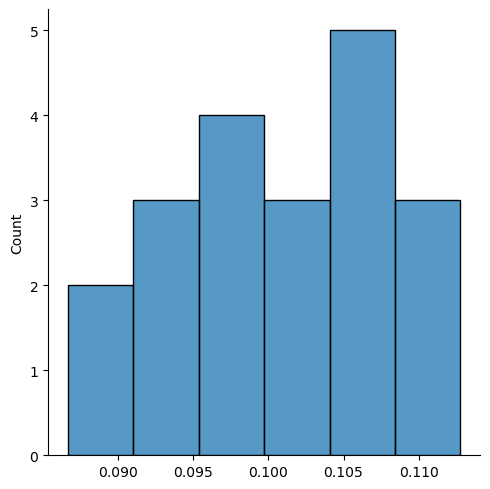

In [21]:
sns.displot(growth_rates)
plt.show()

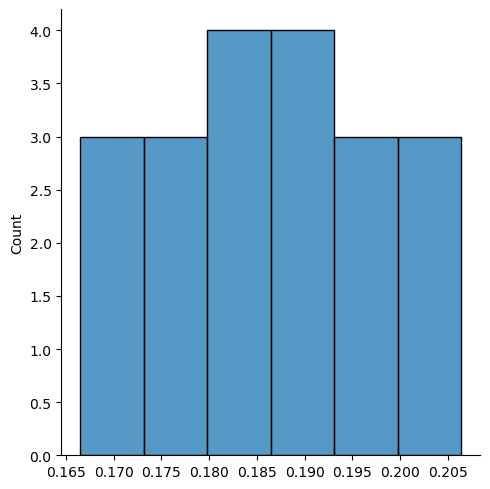

In [22]:
sns.displot(hh_sars)
plt.show()